# org data 

In [2]:
user1_folder='../data/button_sequence/user1'

In [3]:
import os
import glob

# Count CSV files
csv_files = glob.glob(os.path.join(user1_folder, '*.csv'))
print(f'Number of CSV files: {len(csv_files)}')

# Count WAV files
wav_files = glob.glob(os.path.join(user1_folder, '*.wav'))
print(f'Number of WAV files: {len(wav_files)}')

Number of CSV files: 96
Number of WAV files: 96


In [37]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import librosa.display
import torch
from typing import List, Dict, Tuple
from dataclasses import dataclass,field
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

@dataclass
class DatasetConfig:
    inertial_sequence_length: int = 500  # Fixed sequence length for inertial data
    audio_sequence_length: int = 110000  # Fixed sequence length for audio data
    audio_sr: int = 48000  # Audio sampling rate
    n_mfcc: int = 13  # Number of MFCC features
    n_fft: int = 1024  # FFT window size for spectrogram
    hop_length: int = 512  # Hop length for spectrogram
    noise_duration_ms: int = 50  # Duration of noise sample in milliseconds
    inertial_columns: List[str] = field(default_factory=lambda: [
        'gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z'
    ])

class FeatureExtractor:
    def __init__(self, config: DatasetConfig):
        self.config = config
    
    def compute_derivatives_rms(self, data: np.ndarray) -> np.ndarray:
        """
        Compute 1st and 2nd derivatives and their RMS values
        Args:
            data: Raw inertial data of shape (sequence_length, 6)
        Returns:
            RMS features of shape (sequence_length-2, 12)
        """
        # First derivative
        d1 = np.diff(data, axis=0)
        # Second derivative
        d2 = np.diff(d1, axis=0)
        
        # Compute RMS for both derivatives
        d1_rms = np.sqrt(np.mean(d1[:-1] ** 2, axis=1))
        d2_rms = np.sqrt(np.mean(d2 ** 2, axis=1))
        
        return np.column_stack([d1_rms, d2_rms])
    
    def process_inertial_data(self, csv_path: str) -> Tuple[np.ndarray, np.ndarray, int]:
        """
        Process inertial data from CSV file
        Returns:
            Tuple of (raw_data, derivative_rms, original_length)
        """
        # Read CSV
        df = pd.read_csv(csv_path)
        data = df[self.config.inertial_columns].values
        
        # Store original length
        original_length = len(data)
        
        # Truncate or pad to fixed length
        if len(data) > self.config.inertial_sequence_length:
            data = data[:self.config.inertial_sequence_length]
        else:
            pad_length = self.config.inertial_sequence_length - len(data)
            data = np.pad(data, ((0, pad_length), (0, 0)), mode='constant')
        
        # Compute derivatives RMS
        deriv_rms = self.compute_derivatives_rms(data)
        
        return data, deriv_rms, original_length
    
    def denoise_audio_fixed_noise_sample(self, audio: np.ndarray) -> np.ndarray:
        """
        Apply denoising using a fixed noise sample from the first 100ms of the audio
        Args:
            audio: Raw audio signal
        Returns:
            Denoised audio signal
        """
        # Calculate number of samples for noise profile
        noise_samples = int(self.config.noise_duration_ms * self.config.audio_sr / 1000)
        
        # Extract noise profile from the first segment
        noise = audio[:noise_samples]
        noise_power = np.mean(noise**2)
        
        # Initialize denoised audio
        denoised_audio = np.zeros_like(audio)
        
        # Process audio in overlapping windows
        window_size = 1024
        hop_size = window_size // 2
        
        # Process audio in windows
        for pos in range(0, len(audio) - window_size + 1, hop_size):
            # Extract current window
            window = audio[pos:pos + window_size]
            
            # Apply fixed noise profile subtraction
            window_power = np.mean(window**2)
            
            # Calculate gain based on noise profile
            gain = np.maximum(0, 1 - (noise_power / (window**2 + 1e-10)))
            denoised_window = window * gain
            
            # Apply smoothing to reduce artifacts
            if len(denoised_window) > 3:
                denoised_window = savgol_filter(denoised_window, min(5, len(denoised_window) - (len(denoised_window) % 2 - 1)), 2)
            
            # Add to output with overlap-add
            denoised_audio[pos:pos + window_size] += denoised_window * np.hanning(window_size)
        
        # Normalize for overlap-add
        normalization = np.zeros_like(audio)
        hann_window = np.hanning(window_size)
        
        for pos in range(0, len(audio) - window_size + 1, hop_size):
            normalization[pos:pos + window_size] += hann_window
        
        # Avoid division by zero
        normalization[normalization < 1e-10] = 1.0
        
        denoised_audio /= normalization
        
        return denoised_audio
    
    def process_audio_data(self, wav_path: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, int]:
        """
        Process audio data from WAV file
        Args:
            wav_path: Path to WAV file
        Returns:
            Tuple of (raw_audio, denoised_audio, original_spec, denoised_spec, original_mfcc, denoised_mfcc, original_length)
        """
        # Load audio
        audio, sr = librosa.load(wav_path, sr=self.config.audio_sr)
        
        # Store original length
        original_length = len(audio)
        
        # Truncate or pad to fixed length
        if len(audio) > self.config.audio_sequence_length:
            audio = audio[:self.config.audio_sequence_length]
        else:
            audio = np.pad(audio, (0, self.config.audio_sequence_length - len(audio)))
        
        # Apply fixed noise sample denoising
        denoised_audio = self.denoise_audio_fixed_noise_sample(audio)
        
        # Compute original spectrogram
        original_spec = librosa.stft(audio, n_fft=self.config.n_fft, 
                                   hop_length=self.config.hop_length)
        original_spec = np.abs(original_spec)
        
        # Compute denoised spectrogram
        denoised_spec = librosa.stft(denoised_audio, n_fft=self.config.n_fft, 
                                   hop_length=self.config.hop_length)
        denoised_spec = np.abs(denoised_spec)
        
        # Compute original MFCC
        original_mfcc = librosa.feature.mfcc(y=audio, sr=sr, 
                                          n_mfcc=self.config.n_mfcc)
        
        # Compute denoised MFCC
        denoised_mfcc = librosa.feature.mfcc(y=denoised_audio, sr=sr, 
                                          n_mfcc=self.config.n_mfcc)
        
        return audio, denoised_audio, original_spec, denoised_spec, original_mfcc, denoised_mfcc, original_length

def prepare_dataset(folder_list: List[str], label_list: List[int], 
                   config: DatasetConfig = DatasetConfig(), plot: bool = False) -> Dict:
    """
    Prepare dataset from multiple folders with corresponding labels
    Args:
        folder_list: List of folder paths containing CSV and WAV files
        label_list: List of labels corresponding to each folder
        config: Dataset configuration
        plot: Whether to plot the distribution of original lengths and samples
    Returns:
        Dictionary containing processed features and labels
    """
    feature_extractor = FeatureExtractor(config)
    
    # First pass: collect all original lengths for plotting purposes
    inertial_lengths = []
    audio_lengths = []
    all_csv_files = []
    
    for folder in folder_list:
        csv_files = glob.glob(os.path.join(folder, '*.csv'))
        
        for csv_file in csv_files:
            wav_file = csv_file.replace('.csv', '.wav')
            if not os.path.exists(wav_file):
                continue
                
            try:
                # Read CSV to get inertial data length
                df = pd.read_csv(csv_file)
                inertial_lengths.append(len(df))
                
                # Load audio to get audio length
                audio, _ = librosa.load(wav_file, sr=config.audio_sr)
                audio_lengths.append(len(audio))
                
                all_csv_files.append((csv_file, wav_file))
                
            except Exception as e:
                continue
    
    # Plot distribution of original lengths
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.hist(inertial_lengths, bins=20)
        plt.axvline(x=config.inertial_sequence_length, color='r', linestyle='--', 
                   label=f'Fixed length: {config.inertial_sequence_length}')
        min_inertial_length = min(inertial_lengths) if inertial_lengths else 0
        plt.axvline(x=min_inertial_length, color='g', linestyle='--', 
                   label=f'Min length: {min_inertial_length}')
        plt.title('Distribution of Original Inertial Data Lengths')
        plt.xlabel('Length')
        plt.ylabel('Count')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.hist(audio_lengths, bins=20)
        plt.axvline(x=config.audio_sequence_length, color='r', linestyle='--', 
                   label=f'Fixed length: {config.audio_sequence_length}')
        min_audio_length = min(audio_lengths) if audio_lengths else 0
        plt.axvline(x=min_audio_length, color='g', linestyle='--', 
                   label=f'Min length: {min_audio_length}')
        plt.title('Distribution of Original Audio Lengths')
        plt.xlabel('Length')
        plt.ylabel('Count')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    # Process all files with the fixed lengths from config
    dataset = {
        'inertial_raw': [],
        'derivative_rms': [],
        'audio_raw': [],
        'audio_denoised': [],
        'spectrogram_original': [],
        'spectrogram_denoised': [],
        'mfcc_original': [],
        'mfcc_denoised': [],
        'labels': [],
        'inertial_original_lengths': [],
        'audio_original_lengths': []
    }
    
    label_map = {folder: label for folder, label in zip(folder_list, label_list)}
    
    for csv_file, wav_file in all_csv_files:
        try:
            # Process inertial data
            inertial_raw, deriv_rms, inertial_orig_len = feature_extractor.process_inertial_data(csv_file)
            
            # Process audio data with the fixed length from config
            audio_raw, audio_denoised, spec_orig, spec_denoised, mfcc_orig, mfcc_denoised, audio_orig_len = feature_extractor.process_audio_data(wav_file)
            
            # Determine label based on folder
            folder = os.path.dirname(csv_file)
            label = next((label_map[f] for f in label_map if folder.startswith(f)), None)
            
            if label is None:
                continue
                
            # Append to dataset
            dataset['inertial_raw'].append(inertial_raw)
            dataset['derivative_rms'].append(deriv_rms)
            dataset['audio_raw'].append(audio_raw)
            dataset['audio_denoised'].append(audio_denoised)
            dataset['spectrogram_original'].append(spec_orig)
            dataset['spectrogram_denoised'].append(spec_denoised)
            dataset['mfcc_original'].append(mfcc_orig)
            dataset['mfcc_denoised'].append(mfcc_denoised)
            dataset['labels'].append(label)
            dataset['inertial_original_lengths'].append(inertial_orig_len)
            dataset['audio_original_lengths'].append(audio_orig_len)
            
        except Exception as e:
            continue
    
    # Convert lists to numpy arrays
    for key in dataset:
        dataset[key] = np.array(dataset[key])
    
    # Plot the first 10 samples of original and denoised spectrograms and MFCCs if requested
    if plot and len(dataset['spectrogram_original']) > 0 and len(dataset['mfcc_original']) > 0:
        num_samples = min(10, len(dataset['spectrogram_original']))
        fig, axes = plt.subplots(4, num_samples, figsize=(20, 6))
        
        # Plot original spectrograms in the first row
        for i in range(num_samples):
            librosa.display.specshow(librosa.amplitude_to_db(dataset['spectrogram_original'][i], ref=np.max),
                                    y_axis='log', x_axis='time', ax=axes[0, i])
            axes[0, i].set_title(f'Original Spec {i+1}')
            axes[0, i].set_xlabel('')
            axes[0, i].set_ylabel('') if i > 0 else axes[0, i].set_ylabel('Frequency')
        
        # Plot denoised spectrograms in the second row
        for i in range(num_samples):
            librosa.display.specshow(librosa.amplitude_to_db(dataset['spectrogram_denoised'][i], ref=np.max),
                                    y_axis='log', x_axis='time', ax=axes[1, i])
            axes[1, i].set_title(f'Denoised Spec {i+1}')
            axes[1, i].set_xlabel('')
            axes[1, i].set_ylabel('') if i > 0 else axes[1, i].set_ylabel('Frequency')
        
        # Plot original MFCCs in the third row
        for i in range(num_samples):
            librosa.display.specshow(dataset['mfcc_original'][i], x_axis='time', ax=axes[2, i])
            axes[2, i].set_title(f'Original MFCC {i+1}')
            axes[2, i].set_xlabel('')
            axes[2, i].set_ylabel('') if i > 0 else axes[2, i].set_ylabel('MFCC')
        
        # Plot denoised MFCCs in the fourth row
        for i in range(num_samples):
            librosa.display.specshow(dataset['mfcc_denoised'][i], x_axis='time', ax=axes[3, i])
            axes[3, i].set_title(f'Denoised MFCC {i+1}')
            axes[3, i].set_xlabel('Time')
            axes[3, i].set_ylabel('') if i > 0 else axes[3, i].set_ylabel('MFCC')
        
        plt.tight_layout()
        plt.show()
    
    return dataset

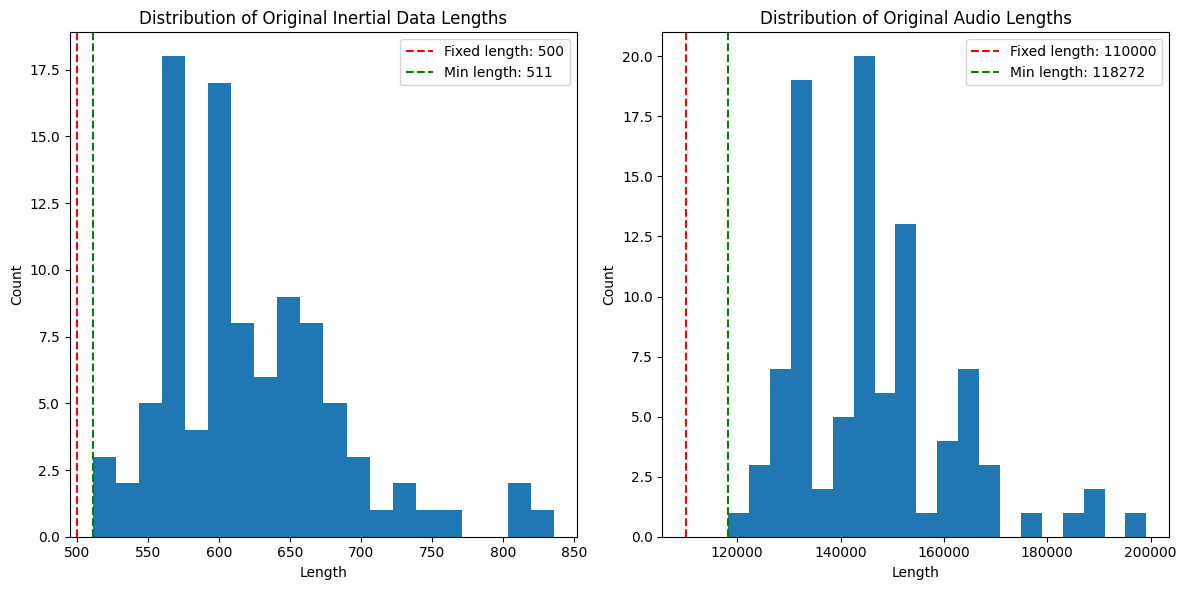

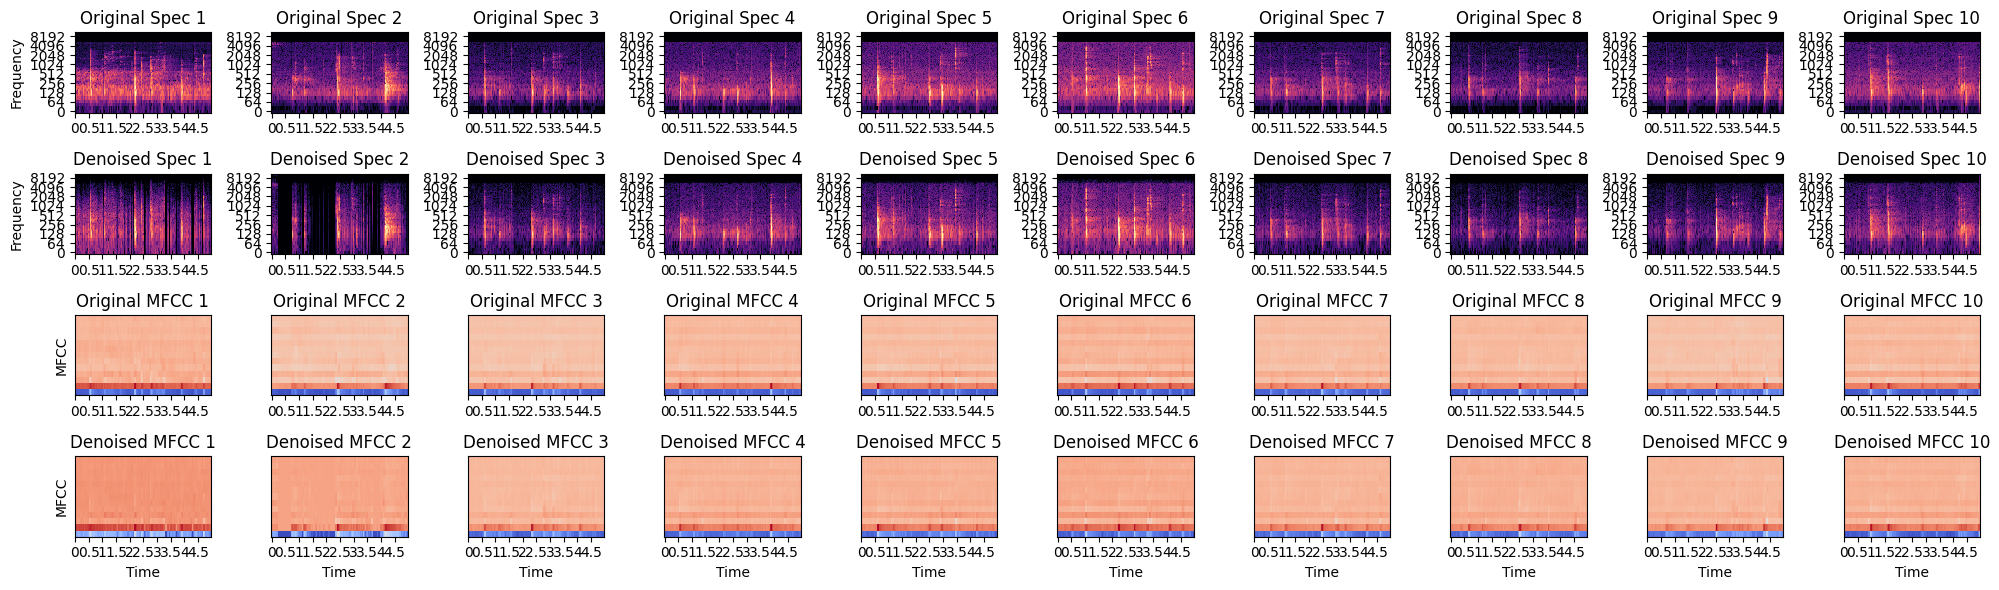

In [38]:
config = DatasetConfig()

folders=['../data/button_sequence/user1']
labels=[0]

dataset = prepare_dataset(folders, labels, config, plot=True)

